In [8]:
# Time of the picked event 2025-04-25T17:33:16
#required packages
import os
from obspy.clients.fdsn.mass_downloader import CircularDomain, MassDownloader, Restrictions
from obspy import UTCDateTime
from obspy.geodetics.base import degrees2kilometers,kilometers2degrees, locations2degrees
from obspy.clients.fdsn import Client

client = Client("KOERI")

begintime=UTCDateTime(2025,4,25,17,33,16,000)
endtime=UTCDateTime(2025,4,25,17,43,16,000)
evla=40.86
evlo=28.43
eqname="20250425"
max_distance_km=80
waveform_dir = f"{eqname}/waveforms"
stationxml_dir = f"{eqname}/stations"
# Create the directory and its subdirectories
os.makedirs(waveform_dir, exist_ok=True)
os.makedirs(stationxml_dir, exist_ok=True)
restrictions = Restrictions( starttime=begintime, endtime=endtime,
                                  reject_channels_with_gaps=True,
                                channel_priorities=["HH[ZNE]", "HN[ZNE]"], minimum_length=0.80,)
                                                              
koeri_client = Client("KOERI")                                
mdl = MassDownloader(providers=[koeri_client])
max_rad=kilometers2degrees(max_distance_km)
domain = CircularDomain(latitude=evla, longitude=evlo, minradius=0.0, maxradius=max_rad)
mdl.download(domain, restrictions, mseed_storage=waveform_dir,
                          stationxml_storage=stationxml_dir)

[2026-01-02 11:37:29,058] - obspy.clients.fdsn.mass_downloader - INFO: Initializing FDSN client(s) for http://eida.koeri.boun.edu.tr.
[2026-01-02 11:37:29,058] - obspy.clients.fdsn.mass_downloader - INFO: Initializing FDSN client(s) for http://eida.koeri.boun.edu.tr.
[2026-01-02 11:37:29,058] - obspy.clients.fdsn.mass_downloader - INFO: Initializing FDSN client(s) for http://eida.koeri.boun.edu.tr.
[2026-01-02 11:37:29,060] - obspy.clients.fdsn.mass_downloader - INFO: Successfully initialized 1 client(s): http://eida.koeri.boun.edu.tr.
[2026-01-02 11:37:29,060] - obspy.clients.fdsn.mass_downloader - INFO: Successfully initialized 1 client(s): http://eida.koeri.boun.edu.tr.
[2026-01-02 11:37:29,060] - obspy.clients.fdsn.mass_downloader - INFO: Successfully initialized 1 client(s): http://eida.koeri.boun.edu.tr.
[2026-01-02 11:37:29,062] - obspy.clients.fdsn.mass_downloader - INFO: Total acquired or preexisting stations: 0
[2026-01-02 11:37:29,062] - obspy.clients.fdsn.mass_downloader - 

{'http://eida.koeri.boun.edu.tr': <obspy.clients.fdsn.mass_downloader.download_helpers.ClientDownloadHelper at 0x78463079aa20>}


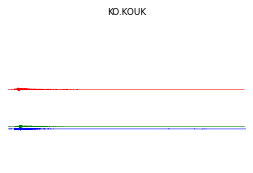
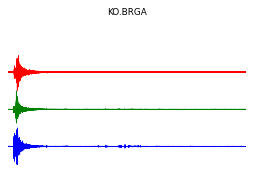
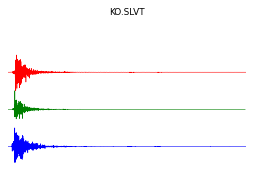
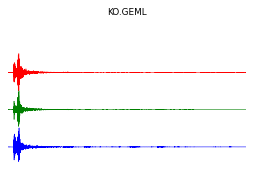
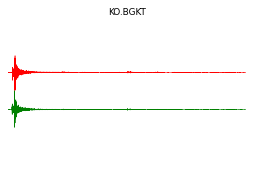
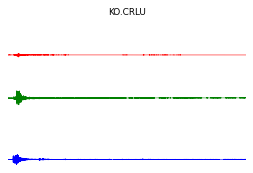
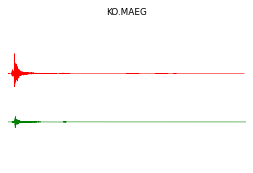
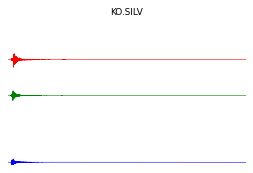
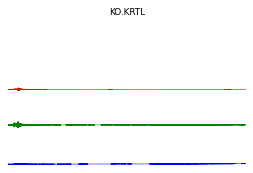
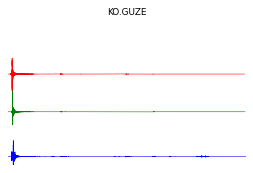
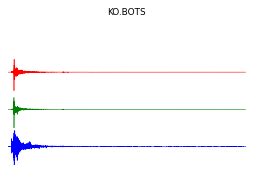
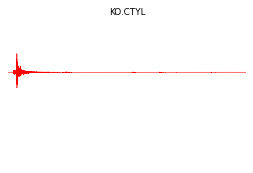
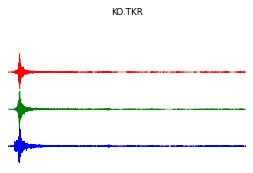
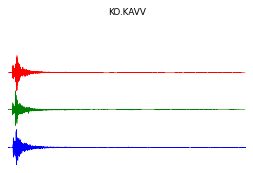
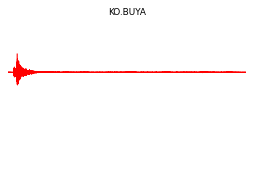
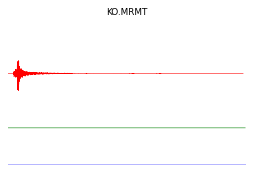
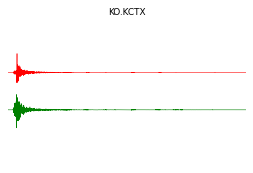
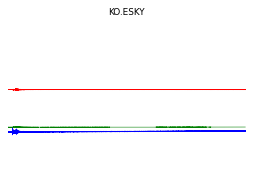
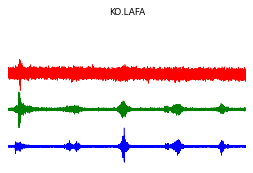

In [9]:
# Create a map showing the event location and stations with waveform plots
import folium
from obspy import read_inventory, read
import glob
import matplotlib.pyplot as plt
import io
import base64
from branca.element import Figure

# Create a map centered on the event location
m = folium.Map(location=[evla, evlo], zoom_start=9, tiles='OpenStreetMap')

# Add event marker (red)
folium.Marker(
    location=[evla, evlo],
    popup=f'Event: {eqname}',
    icon=folium.Icon(color='red', icon='star'),
    tooltip='Event Location'
).add_to(m)

# Function to create a waveform plot as a base64 encoded image
def create_waveform_plot(waveform_files, station_code):
    fig, ax = plt.subplots(figsize=(3, 2), dpi=80)
    
    # Read and plot each component
    colors = ['r', 'g', 'b']
    components = []
    for i, wf_file in enumerate(sorted(waveform_files)[:3]):  # Max 3 components
        try:
            st = read(wf_file)
            tr = st[0]
            # Normalize the data
            data = tr.data / max(abs(tr.data)) if max(abs(tr.data)) > 0 else tr.data
            # Offset each trace
            data = data + (2 - i) * 2
            ax.plot(tr.times(), data, colors[i], linewidth=0.5, label=tr.stats.channel)
            components.append(tr.stats.channel)
        except Exception as e:
            print(f"Error reading {wf_file}: {e}")
    
    ax.set_ylim(-1, 7)
    ax.set_xlim(0, tr.times()[-1] if 'tr' in locals() else 600)
    ax.axis('off')
    ax.set_title(station_code, fontsize=8, pad=2)
    
    plt.tight_layout(pad=0.1)
    
    # Save plot to base64
    buf = io.BytesIO()
    plt.savefig(buf, format='png', bbox_inches='tight', transparent=True)
    buf.seek(0)
    img_base64 = base64.b64encode(buf.read()).decode()
    plt.close(fig)
    
    return img_base64

# Read all station XML files and add station markers with waveforms
station_files = glob.glob(f"{stationxml_dir}/*.xml")
for station_file in station_files:
    try:
        inv = read_inventory(station_file)
        for network in inv:
            for station in network:
                station_code = f'{network.code}.{station.code}'
                
                # Find corresponding waveform files
                waveform_files = glob.glob(f"{waveform_dir}/{station_code}..*mseed")
                
                # Create popup with waveform plot
                if waveform_files:
                    img_base64 = create_waveform_plot(waveform_files, station_code)
                    html = f'''
                    <div style="width: 250px;">
                        <h4>{station_code}</h4>
                        <img src="data:image/png;base64,{img_base64}" width="240">
                        <p>Lat: {station.latitude:.4f}<br>Lon: {station.longitude:.4f}</p>
                    </div>
                    '''
                    popup = folium.Popup(html, max_width=300)
                else:
                    popup = f'{station_code}<br>No waveforms available'
                
                folium.Marker(
                    location=[station.latitude, station.longitude],
                    popup=popup,
                    icon=folium.Icon(color='blue', icon='info-sign'),
                    tooltip=f'{station_code}'
                ).add_to(m)
    except Exception as e:
        print(f"Error reading {station_file}: {e}")

# Add a circle showing the search radius
folium.Circle(
    location=[evla, evlo],
    radius=max_distance_km * 1000,  # Convert km to meters
    color='red',
    fill=False,
    opacity=0.5,
    tooltip=f'{max_distance_km} km radius'
).add_to(m)

# Display the map
m


KO.BGKT_HH:


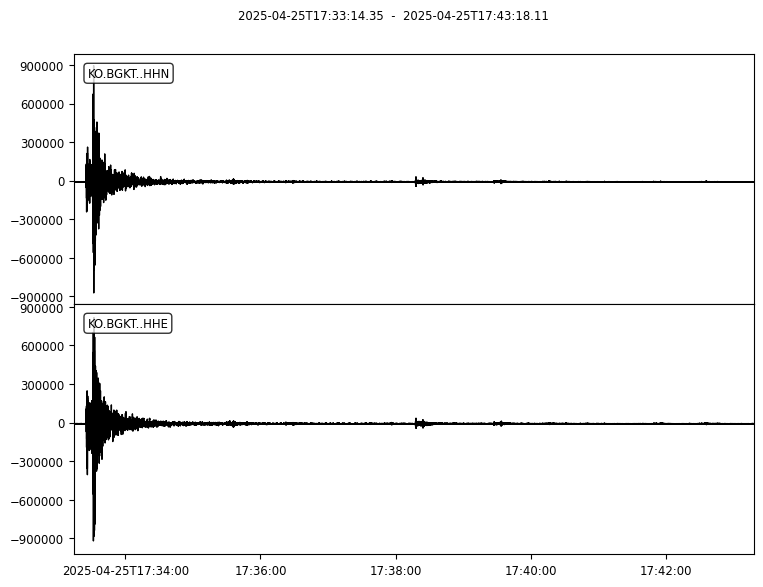


KO.BOTS_HH:


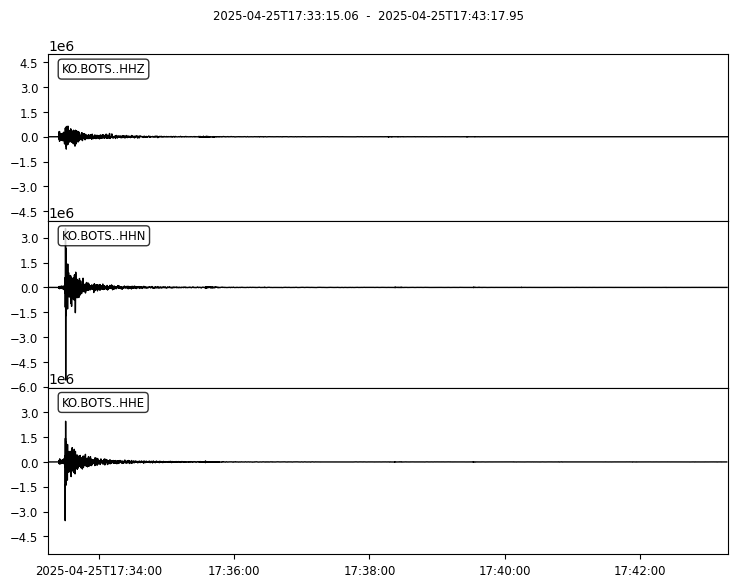


KO.BRGA_HN:


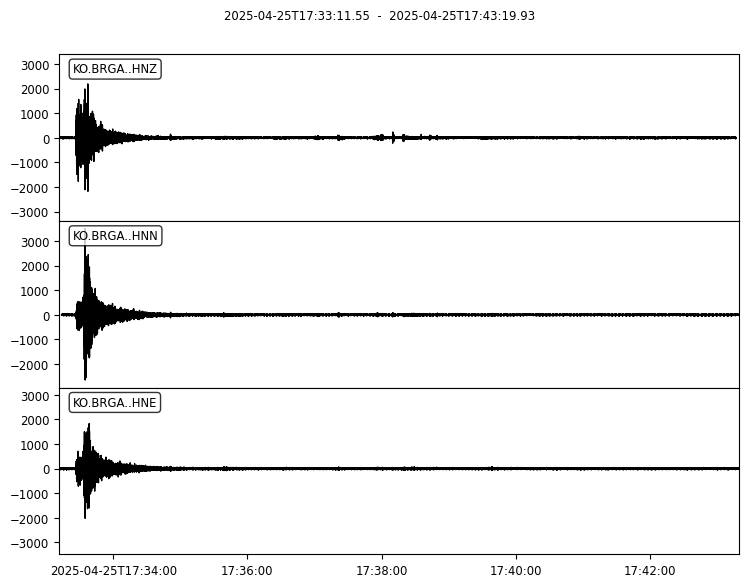


KO.BUYA_HN:


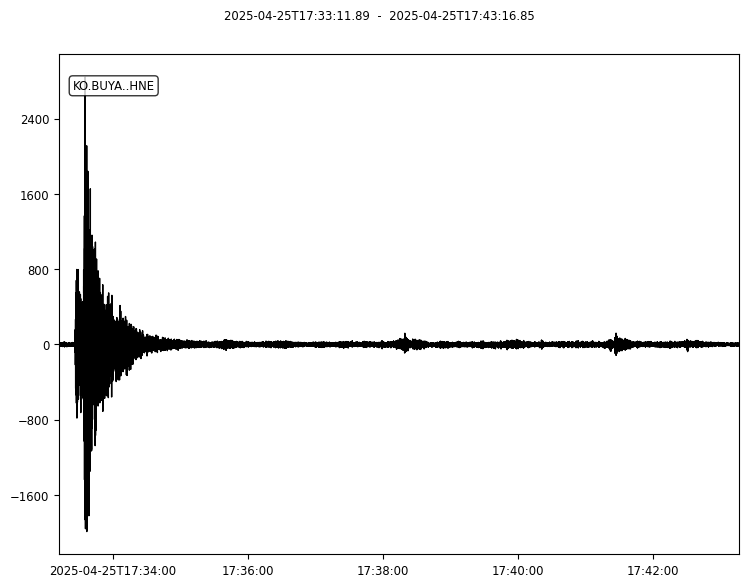


KO.CRLU_HN:


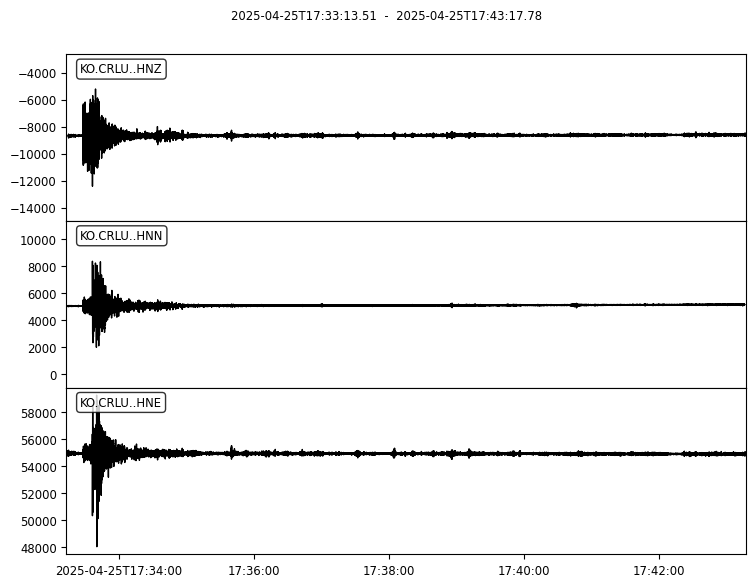


KO.CTYL_HH:


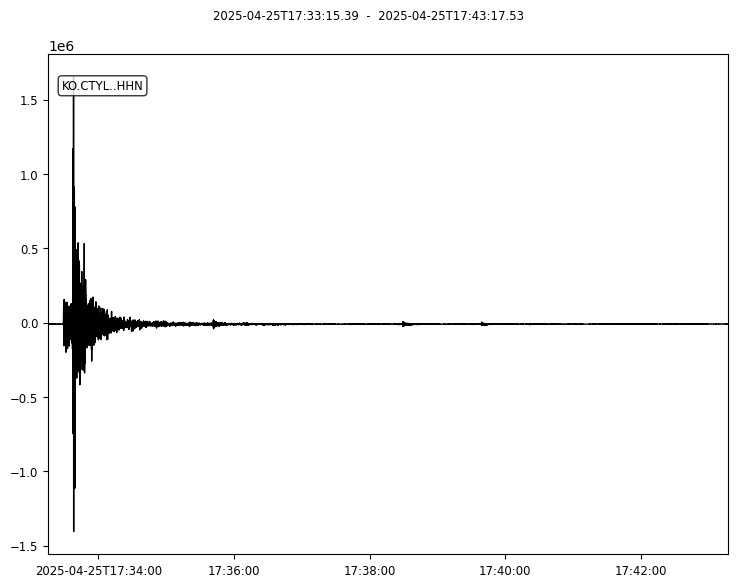


KO.ESKY_HN:


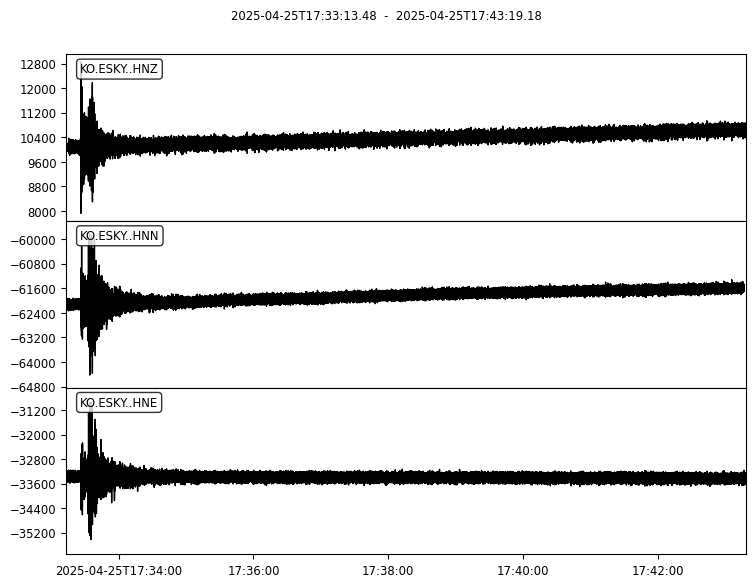


KO.GEML_HH:


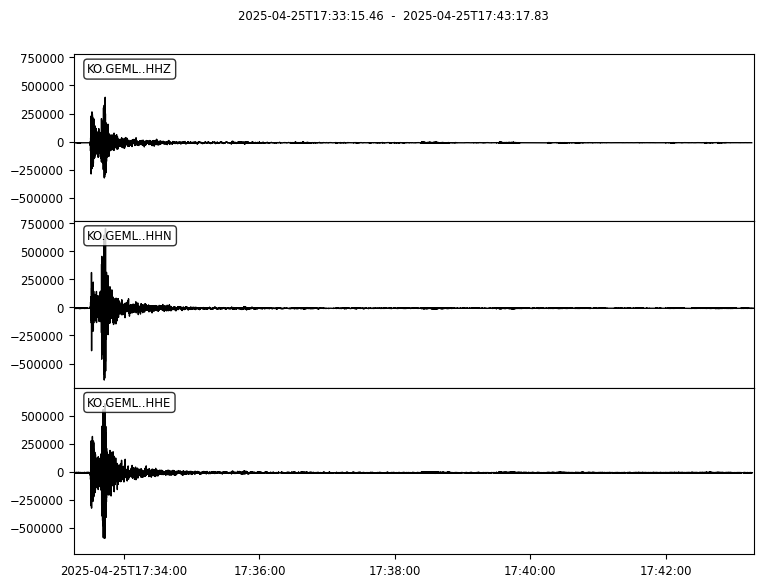


KO.GUZE_HN:


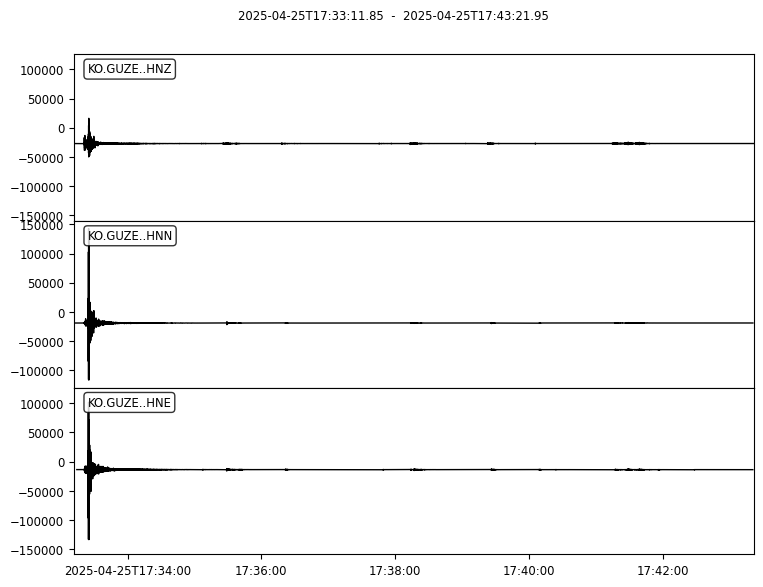


KO.KAVV_HH:


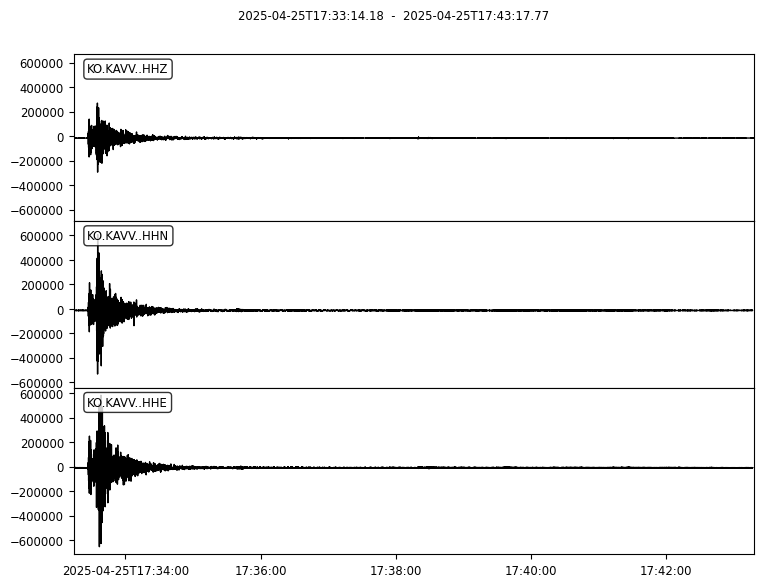


KO.KCTX_HH:


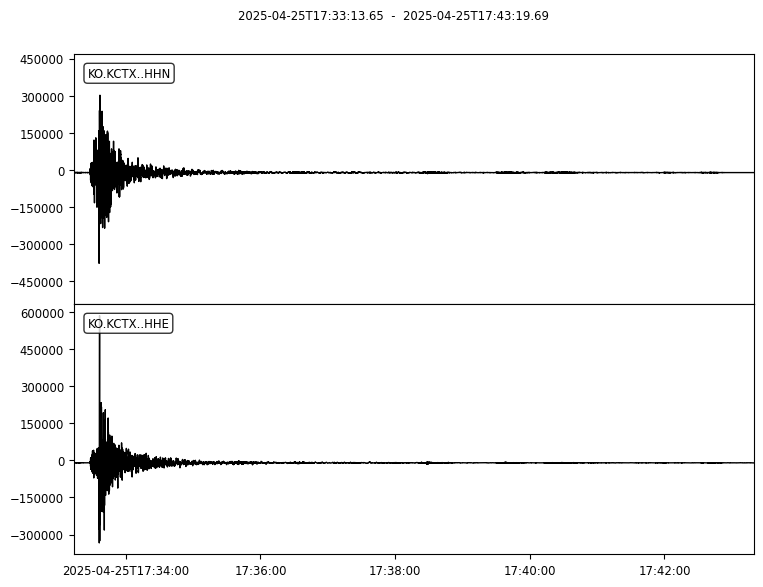


KO.KOUK_HN:


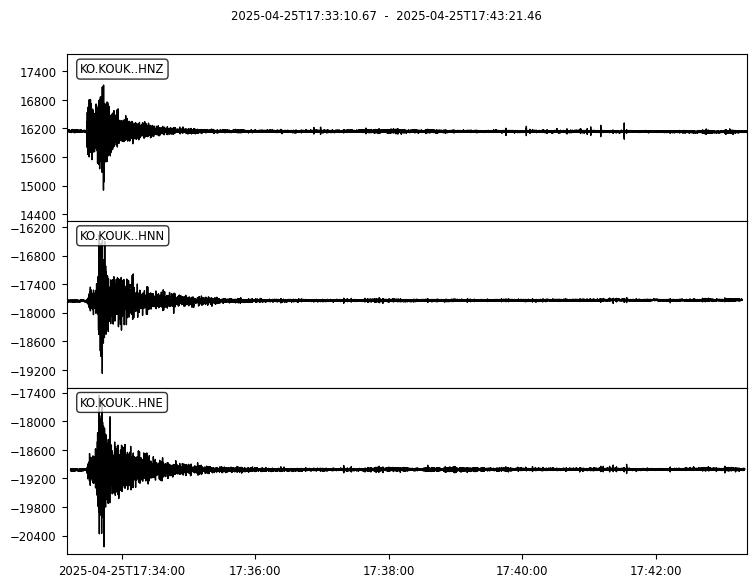


KO.KRTL_HN:


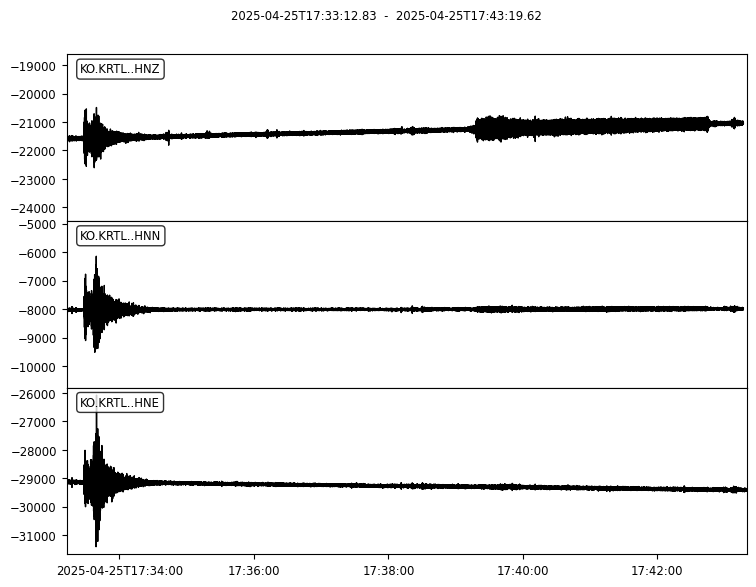


KO.LAFA_HN:


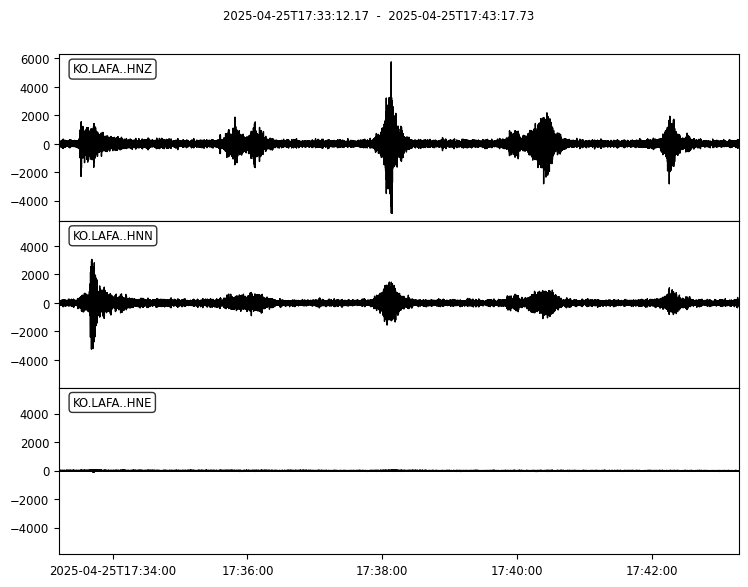


KO.MAEG_HN:


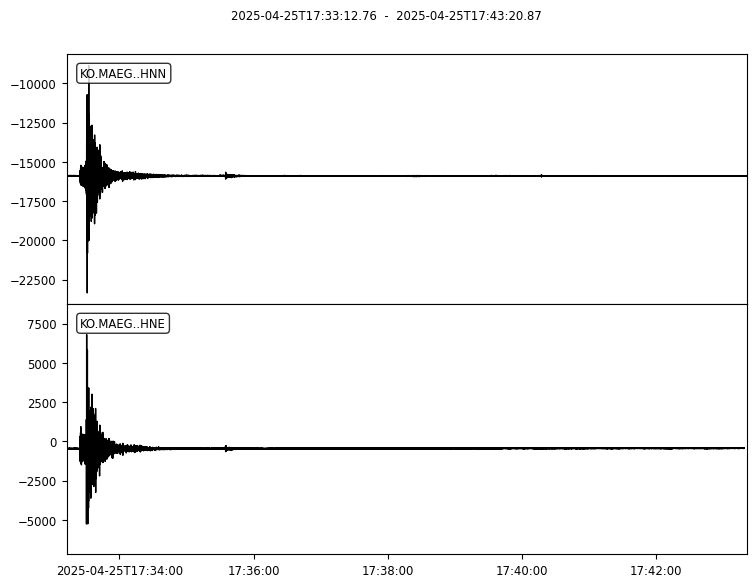


KO.MRMT_HH:


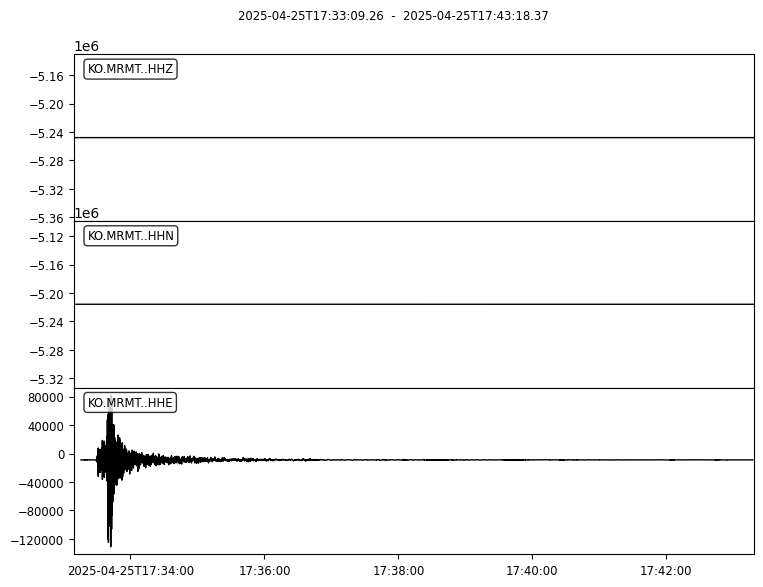


KO.SILV_HN:


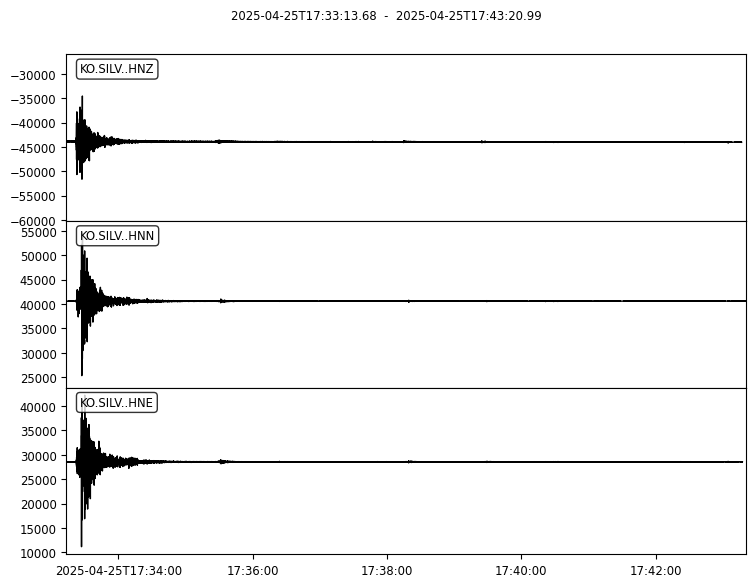


KO.SLVT_HH:


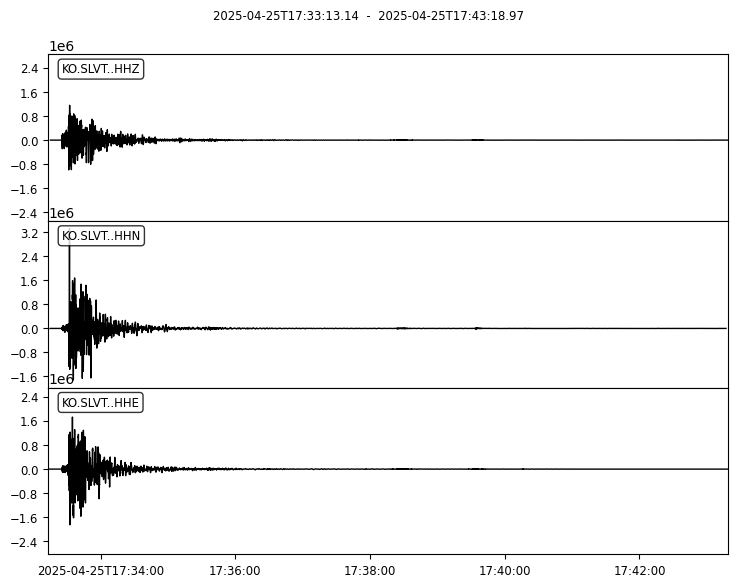


KO.TKR_HH:


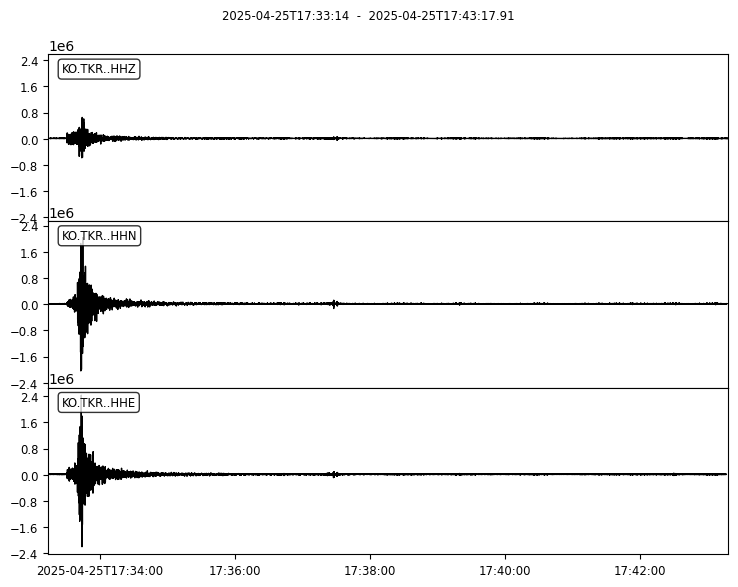

In [11]:
# Plot all station waveforms using ObsPy's plot method
from obspy import read, Stream
import glob

# Get all waveform files
waveform_files = glob.glob(f"{waveform_dir}/*.mseed")

# Create a dictionary to group by station and channel type
station_streams = {}

for wf_file in waveform_files:
    # Read the trace
    st = read(wf_file)
    tr = st[0]
    
    # Extract station code and channel type (HH or HN)
    station_code = f"{tr.stats.network}.{tr.stats.station}"
    channel_type = tr.stats.channel[:2]  # Get HH or HN
    
    # Create a key for this station-channel combination
    key = f"{station_code}_{channel_type}"
    
    # Add to the appropriate stream
    if key not in station_streams:
        station_streams[key] = Stream()
    
    station_streams[key] += tr

# Plot each station's waveforms
for key, stream in sorted(station_streams.items()):
    print(f"\n{key}:")
    stream.plot(size=(800, 600))

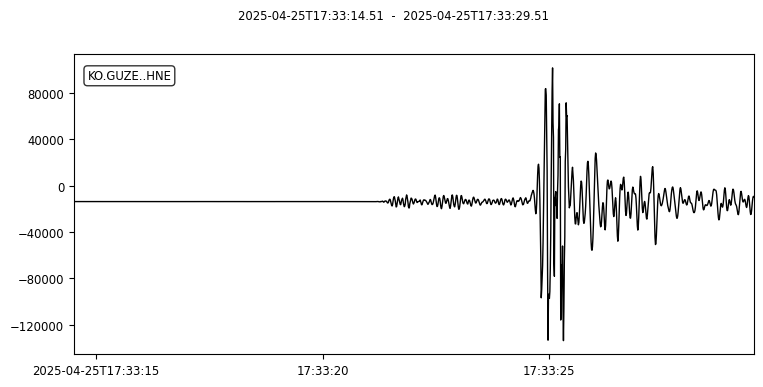

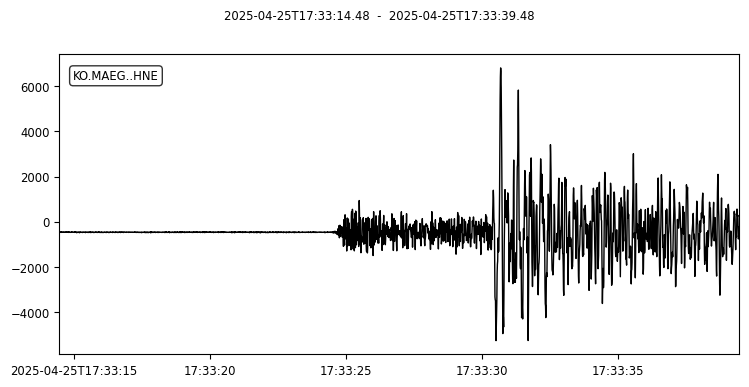

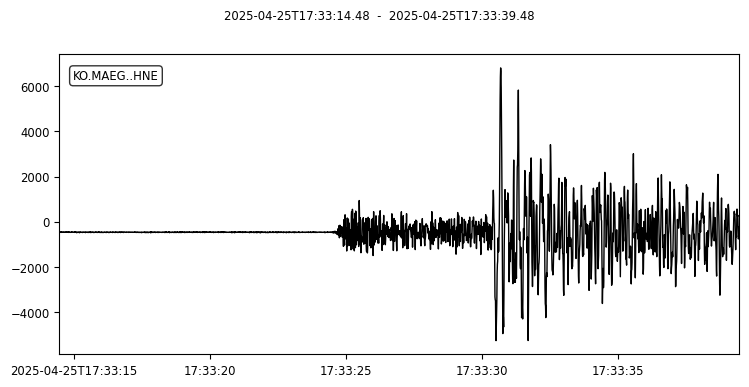

In [ ]:
# show the first 10 seconds of GUZE
st = read(f"{waveform_dir}/KO.GUZE..HNE__20250425T173316Z__20250425T174316Z.mseed")
st.trim(starttime=st[0].stats.starttime, endtime=st[0].stats.starttime + 15)
st.plot(size=(800, 400))

st = read(f"{waveform_dir}/KO.MAEG..HNE__20250425T173316Z__20250425T174316Z.mseed")
st.trim(starttime=st[0].stats.starttime, endtime=st[0].stats.starttime + 25)
st.plot(size=(800, 400))

